In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

In [3]:
print("\u2022 Using TensorFlow Version:", tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.4.1
• GPU Device Found.


In [5]:
DATASET_DIR = '/content/drive/MyDrive/capstone_project/capstone_machine_learning/capstone_dataset/arranged_dataset' # Change based on dataset dir on your system/device
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VAL_DIR = os.path.join(DATASET_DIR, 'validation')
TEST_DIR = os.path.join(DATASET_DIR, 'test')
BATCH_SIZE = 64

In [6]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized
        batch_size=BATCH_SIZE,
        class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 10000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


In [7]:
NUM_CLASSES = train_generator.num_classes
print(NUM_CLASSES)

5


In [8]:
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [9]:
inputs = tf.keras.Input(shape=(224,224,3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax',  use_bias=True, name='Logits')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
Logits (Dense)               (None, 5)                 6405  

In [10]:
lr = 0.0001
momentum = 0.9
sgd = tf.keras.optimizers.SGD(lr=lr, momentum=momentum)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
steps_train = np.ceil(train_generator.n/BATCH_SIZE)
steps_val = np.ceil(test_generator.n/BATCH_SIZE)

history = model.fit(train_generator,
          steps_per_epoch=steps_train,
          validation_data=test_generator,
          validation_steps=steps_val,
          epochs=20,
          shuffle=True,
          verbose=1)

Epoch 1/20
157/157 [==============================] - 372s 2s/step - loss: 1.7190 - accuracy: 0.2107 - val_loss: 1.5842 - val_accuracy: 0.3125
Epoch 2/20
157/157 [==============================] - 334s 2s/step - loss: 1.6361 - accuracy: 0.2307 - val_loss: 1.5650 - val_accuracy: 0.3255
Epoch 3/20
157/157 [==============================] - 327s 2s/step - loss: 1.6025 - accuracy: 0.2529 - val_loss: 1.5477 - val_accuracy: 0.3350
Epoch 4/20
157/157 [==============================] - 327s 2s/step - loss: 1.5698 - accuracy: 0.2900 - val_loss: 1.5190 - val_accuracy: 0.3970
Epoch 5/20
157/157 [==============================] - 323s 2s/step - loss: 1.5402 - accuracy: 0.3070 - val_loss: 1.4999 - val_accuracy: 0.3590
Epoch 6/20
157/157 [==============================] - 327s 2s/step - loss: 1.5177 - accuracy: 0.3320 - val_loss: 1.4835 - val_accuracy: 0.3630
Epoch 7/20
157/157 [==============================] - 326s 2s/step - loss: 1.5081 - accuracy: 0.3337 - val_loss: 1.4718 - val_accuracy: 0.4095

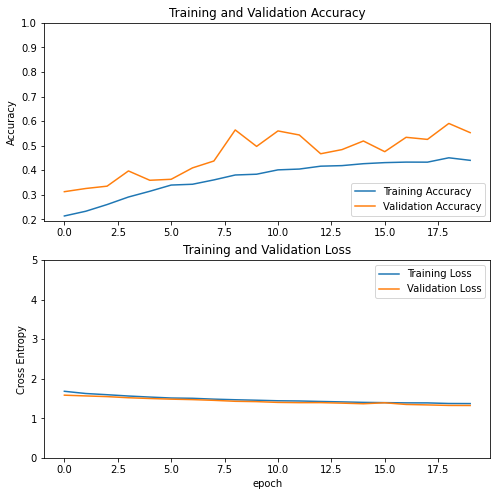

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
predict = model.predict(test_generator)

In [14]:
predict.argmax(1)[:100]

array([1, 3, 3, 3, 3, 0, 3, 2, 4, 3, 1, 1, 0, 4, 3, 3, 3, 2, 3, 0, 3, 1,
       3, 0, 0, 3, 0, 3, 1, 1, 4, 0, 0, 2, 3, 4, 2, 1, 2, 0, 0, 3, 4, 1,
       2, 4, 1, 1, 0, 0, 3, 3, 3, 4, 4, 0, 3, 4, 1, 0, 0, 0, 0, 2, 1, 3,
       2, 1, 4, 3, 4, 4, 4, 1, 3, 3, 0, 3, 0, 2, 0, 0, 0, 3, 3, 3, 1, 2,
       3, 0, 1, 3, 3, 1, 3, 4, 3, 3, 1, 4])

In [15]:
MODEL_DIR = "/content/drive/MyDrive/capstone_machine_learning/capstone_notebooks/Models"
model.save(os.path.join(MODEL_DIR, 'model_retrain_mobilenetv2'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/capstone_machine_learning/capstone_notebooks/Models/model_retrain_mobilenetv2/assets
